# Human Activity Recognition with Fast.ai v2

##**01. Overview**





####Environment Setup

In [ ]:
%%writefile setup.sh
pip3 install sklearn --quiet
pip3 install torch torchvision --quiet
pip3 install --upgrade fastai --quiet
wget https://archive.ics.uci.edu/ml/machine-learning-databases/00240/UCI%20HAR%20Dataset.zip
mkdir HARDataset
PATH="./HARDataset/UCI HAR Dataset/"

In [ ]:
!sh setup.sh

####Imports

In [ ]:
import zipfile
import time

from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot

import torch 
import torch.nn as nn
import torch.optim as optim
from tqdm import tqdm
from IPython.core.debugger import set_trace
from statsmodels.graphics.tsaplots import plot_pacf
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

from fastai import *
from fastai.text.all import *

from keras.utils import to_categorical

####CUDA Setup

In [ ]:
if torch.cuda.is_available():       
    device = torch.device("cuda")
    print(f'There are {torch.cuda.device_count()} GPU(s) available.')
    print('Device name:', torch.cuda.get_device_name(0))

else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
!nvidia-smi

##**02. The Problem Statement**

##**03. The Dataset**


**Hardware Used:** Samsung Galaxy S II

**Experiment Design:**
[1] Records 30 volunteer subjects, ages 19-48 years, performed six activities with mobile embedded accelerometer and gyroscope around the waist. captured 3-axial linear acceleration and 3-axial angular velocity at a constant rate of 50Hz. The obtained dataset has been randomly partitioned into two sets, where 70% of the volunteers was selected for generating the training data and 30% the test data.


**Classes:**

- **0**: Walking
- **1**: Walking Upstairs
- **2**: Walking Downstairs
- **3**: Sitting 
- **4**: Standing 
- **5**: Laying 


[`[1]`](https://archive.ics.uci.edu/ml/datasets/human+activity+recognition+using+smartphones) Davide Anguita, Alessandro Ghio, Luca Oneto, Xavier Parra and Jorge L. Reyes-Ortiz. A Public Domain Dataset for Human Activity Recognition Using Smartphones. 21th European Symposium on Artificial Neural Networks, Computational Intelligence and Machine Learning, ESANN 2013. Bruges, Belgium 24-26 April 2013.

In [ ]:
data_file = zipfile.ZipFile("/content/UCI HAR Dataset.zip")
data_file.extractall("./HARDataset/")

####**03\a. Data Exploration**

In [ ]:
def load_data(filepath):
  '''
  '''
  data = read_csv(filepath, header=None, delim_whitespace=True)
  return data.values

In [ ]:
data = load_file(f'{$PATH}/train/Inertial Signals/total_acc_y_train.txt')
print(data.shape)

**Claass Distribution**

Label Map:

- **0**: Walking
- **1**: Walking Upstairs
- **2**: Walking Downstairs
- **3**: Sitting 
- **4**: Standing 
- **5**: Laying

In [ ]:
label_map  ={
    "0" :"Walking", 
    "1": "Walking Upstairs", 
    "2": "Walking Downstairs"
    "3": "Sitting",
    "4": "Standing", 
    "5": "Laying"
}

In [ ]:
def class_breakdown(data):
  '''
  Summarize the balance of classes in an output variable column.

  Arguments
  ---
  data - 

  '''
	data_df = pd.DataFrame(data)
	counts = data_df.groupby(0).size().values
	for i in range(len(counts)):
		percent = counts[i] / len(data_df) * 100
		print(f'Class={label_map[str(i+1])}, total={counts[i]}, percentage={percent}')

**Train**

In [ ]:
trainy = load_file('HARDataset/train/y_train.txt')
print('Label Distribution - Train Dataset')
class_breakdown(trainy)

**Test**

In [ ]:
 
testy = load_file('HARDataset/test/y_test.txt')
print('Label Distribution -Test Dataset')
class_breakdown(testy)

**All**

In [ ]:
print('Label Distribution - Both')
combined = vstack((trainy, testy))
class_breakdown(combined)

###**03\b. Data Preprocessing**

In [ ]:
def reshape_observations(filenames):
  '''
  To Do: Docs
  '''
  observations = list()
  for name in filenames:
    data = load_data($PATH + name)
    observations.append(data)
  reshaped_obvs = dstack(observations)
  return reshaped_obvs


def load_data_by_split(split):
  '''
  To Do: Docs
  '''
  filepath = $PATH + split  + '/Inertial Signals/'
  filenames = list()

  filenames += ['total_acc_x_'+split+'.txt', 
                'total_acc_y_'+split+'.txt', 
                'total_acc_z_'+split+'.txt']

  filenames += ['body_acc_x_'+split+'.txt', 
                'body_acc_y_'+split+'.txt',
                'body_acc_z_'+split+'.txt']

  filenames += ['body_gyro_x_'+split+'.txt', 
                'body_gyro_y_'+split+'.txt', 
                'body_gyro_z_'+split+'.txt']
  
  X = reshape_observations(filenames, filepath)
  y = load_data($PATH + split + '/y_'+split+'.txt')
  return X, y


def load_dataset(prefix=''):
  '''
  To Do: Docs
  '''
  trainX, trainy = load_data_by_split('train', 
                                     $PATH + 'HARDataset/UCI HAR Dataset/')
  
  print(f"trainX Shape: {trainX.shape}, trainy Shape: {trainy.shape}")

  testX, testy = load_data_by_split('test', 
                                    $PATH + 'HARDataset/UCI HAR Dataset/')
  
  print(f"testX Shape: {testX.shape}, testy Shape: {testy.shape}")
  trainy = to_categorical(trainy - 1)
  testy = to_categorical(testy - 1)
  print(f"trainX Shape: {trainX.shape}, trainy Shape: {trainy.shape}, testX Shape: {testX.shape}, testy: {testy.shape}")
  return trainX, trainy, testX, testy


In [ ]:
trainX, trainy, testX, testy = load_dataset(PATH)

(7352, 128, 9) (7352, 1)
(2947, 128, 9) (2947, 1)
(7352, 128, 9) (7352, 6) (2947, 128, 9) (2947, 6)


**Split fastai style and creat Training Loaders**

In [ ]:
splits = RandomSplitter(seed=2020)(range_of(trainX))

In [ ]:
print(splits)

In [ ]:
data = Datasets(list(range(len(trainX))), 
                [lambda i : trainX[i], 
                 lambda i : trainy[i]], 
                splits=splits)
dls = data.dataloaders(bs=64)

In [ ]:
#print(data.n)

###**04. The Model**

In [ ]:
class HARModel(nn.Module):
  '''

  '''
  def __init__(self, input_size, output_size):
      super(HARModel, self).__init__()
      self.conv1 = nn.Conv1d(input_size, 64, kernel_size=7)
      self.conv1_bn = nn.BatchNorm1d(64)
      self.conv2 = nn.Conv1d(64, 128, kernel_size=3)
      self.conv2_bn = nn.BatchNorm1d(128)
      self.conv3 = nn.Conv1d(128, 256, kernel_size=1)
      self.conv3_bn = nn.BatchNorm1d(256)
      self.drop = nn.Dropout(0.5)
      self.pool = nn.AdaptiveAvgPool1d(10)
      self.linear = nn.Linear(10*256, output_size)
      self.linear_bn = nn.BatchNorm1d(output_size)
      self.out = nn.Linear(output_size, output_size)
      self.softmax = nn.Softmax(1)

  def forward(self, x):
      x = F.relu(self.conv1(x))
      x = self.conv1_bn(x)
      x = F.relu(self.conv2(x))
      x = self.conv2_bn(x)
      x = F.relu(self.conv3(x))
      x = self.conv3_bn(x)
      x = self.pool(x)
      x = x.view(-1, 10*256)
      x = F.relu(self.linear(x))
      x = self.drop(self.linear_bn(x))
      x = self.out(x)
      return self.softmax(x)

**Model Params**

In [ ]:
n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]

In [ ]:
model = HARModel(n_timesteps, n_outputs)

###**05. Training with fast.ai**

In [ ]:
learn = Learner(dls, model, loss_func=nn.MSELoss())
learn = learn.to_fp16()

**Find optimal leaarning rate**

SuggestedLRs(lr_min=0.06309573650360108, lr_steep=0.0003311311302240938)

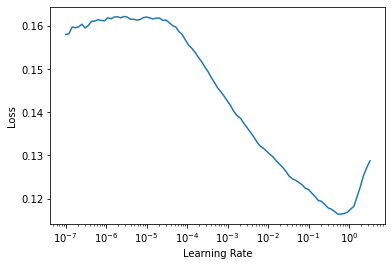

In [ ]:
learn.lr_find()

**Fit.**

In [ ]:
learn.fit_one_cycle(20, 1e-1)

epoch,train_loss,valid_loss,time
0,0.091199,0.058522,00:01
1,0.075800,0.061117,00:01
2,0.066280,0.042817,00:02
3,0.063133,0.042714,00:01
4,0.057506,0.044891,00:01
5,0.050285,0.028771,00:01
6,0.052515,0.046820,00:01
7,0.047652,0.050451,00:01
8,0.045135,0.035472,00:02
9,0.043985,0.031568,00:01


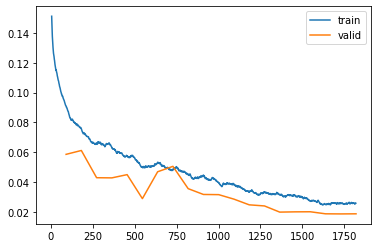

In [ ]:
learn.recorder.plot_loss()

In [ ]:
learn.save('har_model')

###**06. Inference Test**

In [ ]:
test_dl = learn.dls.test_dl(testX)

In [ ]:
def InferenceTest(test_data, learner,):
  '''
  Runs inference on test data loader. return

  Args
  ------
  test_data - DataLoader (torch)
  learner - Learner (fastai)
  '''
  start = time.time()
  preds, _ = learn.get_preds(dl=test_dl)
  preds = [int(x) for x in (np.array(torch.argmax(preds, dim=1))) ]
  end = time.time()
  print(f"Inference on {len(testX)} items took {end-start} seconds.")
  print(f"Test Accuracy: {accuracy_score([np.argmax(x) for x in testy], preds)}")
  return preds 

preds = InferenceTest(test_dl, learn)

Inference on 2947 items took 0.38579773902893066 seconds.


In [ ]:
#print(f"Test Accuracy: {accuracy_score([np.argmax(x) for x in testy], preds)}")

0.8856464200882254
